# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-28 21:21:39,417 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


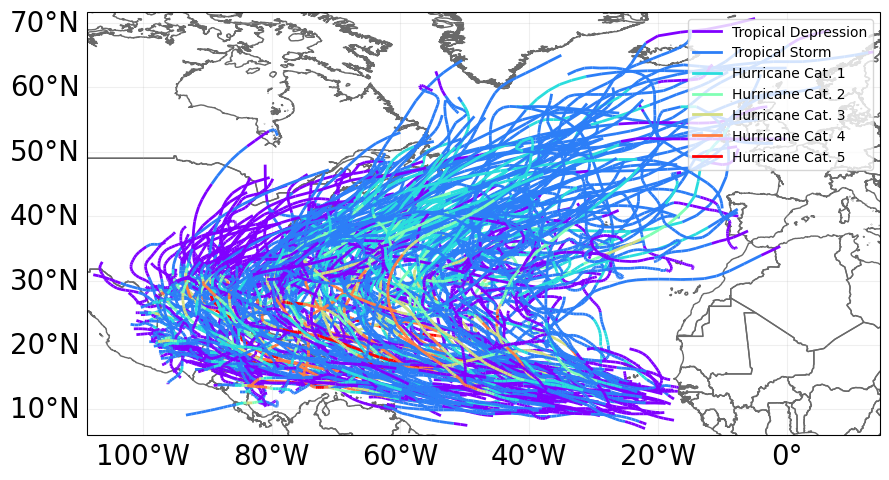

In [3]:
ax = tc_tracks.plot()

### Normalise data

In [3]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [4]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8070, 42, 3): 8070 contexts of length 42 with 3 features each
Test contexts have shape (1029, 42, 3): 1029 contexts of length 42 with 3 features each


### Predict time series and plot in original coordinates

In [5]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [6]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [7]:
contexts['train'].shape

(8070, 42, 3)

In [8]:
stop = 2500
model, fit_time = timer(model.fit)(contexts['train'][:stop])

(1, 42, 3)
(1, 13, 3)


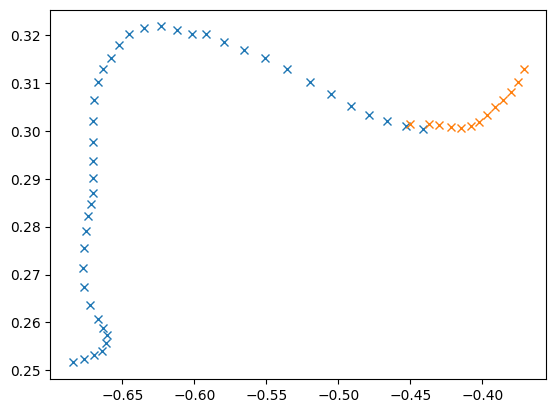

In [9]:
idx = np.random.randint(0, contexts["train"].shape[0])
initial_context = contexts['train'][idx]
print(initial_context.shape)
ts = predict_time_series(model, initial_context, n_steps=13)
print(ts.shape)
plt.plot(initial_context.data[0, :, 0], initial_context.data[0, :, 1], "x")
plt.plot(ts[0, :, 0], ts[0, :, 1], "x")

NOTE: Checkout from kooplearn._src.operator_regression.dual import predict

This function can predict for several time steps but only outputs the last one. Predicting a given context for several timesteps leads probably to something different than predicting one time step ahead, building the new context by shifting to this, and compute the next time step prediction and so on. Could be interesting to compare these two things in terms of runtime and accuracy. Predicting several time steps for given context without shift should be much faster, since only matrix multiplication needs to be applied iteratively. For this predict() needs to be slightly modified to also return intermediate results.

## Train and compare models

In [10]:
from klearn_tcyclone.models_utils import runner

In [12]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [13]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    # 'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

Length scale: 50.0


In [14]:
results = {}
for name in models.keys():
    results[name] = []
for ((name, model), stop) in product(models.items(), train_stops):
    print(f"\nModel: {name}", f'Training points: {stop}')
    results[name].append(runner(model, contexts, stop))


Model: Randomized-RRR Training points: 316
Fitting of model took 0.24s with train RMSE of 0.04407 and test RMSE of 0.04293.

Model: Randomized-RRR Training points: 707
Fitting of model took 0.77s with train RMSE of 0.03504 and test RMSE of 0.03604.

Model: Randomized-RRR Training points: 1584
Fitting of model took 2.03s with train RMSE of 0.03119 and test RMSE of 0.03265.

Model: Randomized-RRR Training points: 3548
Fitting of model took 4.87s with train RMSE of 0.03039 and test RMSE of 0.03191.

Model: Randomized-RRR Training points: 7943
Fitting of model took 27.66s with train RMSE of 0.03080 and test RMSE of 0.03256.

Model: Nystroem-RRR Training points: 316


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


Fitting of model took 2.88s with train RMSE of 0.07205 and test RMSE of 0.07056.

Model: Nystroem-RRR Training points: 707


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


Fitting of model took 2.68s with train RMSE of 0.05622 and test RMSE of 0.05808.

Model: Nystroem-RRR Training points: 1584


Fitting of model took 3.09s with train RMSE of 0.05288 and test RMSE of 0.05600.

Model: Nystroem-RRR Training points: 3548


The rank attribute has been updated to 17.
Consider decreasing the rank parameter.


Fitting of model took 2.93s with train RMSE of 0.04886 and test RMSE of 0.05156.

Model: Nystroem-RRR Training points: 7943


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


Fitting of model took 3.28s with train RMSE of 0.05183 and test RMSE of 0.05474.


In [15]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for Randomized-RRR: 1.00x
Average fitting time speed-up for Nystroem-RRR: 2.22x


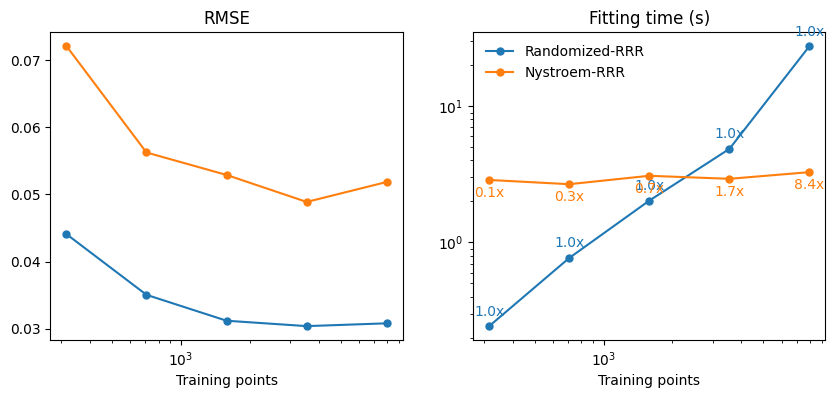

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[0]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")



### ModelBenchmark class

The above functionality (and a bit more) is combined in the ModelBenchmark class.

In [11]:
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark

In [12]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
context_length = 42
feature_list = ["lat", "lon"]
scaler = LinearScaler()


reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

2024-09-28 21:21:56,233 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Length scale: 50.0


In [13]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [14]:
model_benchmarks = {
    name: ModelBenchmark(
        model,
        feature_list,
        tc_tracks_train,
        tc_tracks_test,
        scaler=scaler,
        context_length=context_length,
    )
    for name, model in models.items()
}

In [15]:
print([mb.get_info() for mb in model_benchmarks.values()])

Train contexts have shape (7753, 42, 2): 7753 contexts of length 42 with 2 features each.
Test contexts have shape (1346, 42, 2): 1346 contexts of length 42 with 2 features each.
Train contexts have shape (7753, 42, 2): 7753 contexts of length 42 with 2 features each.
Test contexts have shape (1346, 42, 2): 1346 contexts of length 42 with 2 features each.
Train contexts have shape (7753, 42, 2): 7753 contexts of length 42 with 2 features each.
Test contexts have shape (1346, 42, 2): 1346 contexts of length 42 with 2 features each.
[None, None, None]


In [16]:
results = {name: mb.train_model(train_stops) for name, mb in model_benchmarks.items()}


Model training: Training points: 316


Fitting of model took 1.14s with train RMSE of 0.03368 and test RMSE of 0.03414.

Model training: Training points: 707


Fitting of model took 1.17s with train RMSE of 0.02367 and test RMSE of 0.02162.

Model training: Training points: 1584


Fitting of model took 1.92s with train RMSE of 0.02137 and test RMSE of 0.01889.

Model training: Training points: 3548


Fitting of model took 5.43s with train RMSE of 0.01939 and test RMSE of 0.01687.

Model training: Training points: 7943


Fitting of model took 30.65s with train RMSE of 0.01935 and test RMSE of 0.01687.

Model training: Training points: 316
Fitting of model took 0.28s with train RMSE of 0.03368 and test RMSE of 0.03414.

Model training: Training points: 707
Fitting of model took 0.71s with train RMSE of 0.02368 and test RMSE of 0.02162.

Model training: Training points: 1584
Fitting of model took 1.50s with train RMSE of 0.02137 and test RMSE of 0.01889.

Model training: Training points: 3548
Fitting of model took 4.25s with train RMSE of 0.01939 and test RMSE of 0.01687.

Model training: Training points: 7943
Fitting of model took 27.85s with train RMSE of 0.01935 and test RMSE of 0.01687.

Model training: Training points: 316


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Fitting of model took 3.12s with train RMSE of 0.06067 and test RMSE of 0.05996.

Model training: Training points: 707


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


Fitting of model took 4.65s with train RMSE of 0.04668 and test RMSE of 0.04286.

Model training: Training points: 1584


Fitting of model took 5.87s with train RMSE of 0.04352 and test RMSE of 0.03892.

Model training: Training points: 3548


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Fitting of model took 2.70s with train RMSE of 0.04309 and test RMSE of 0.03805.

Model training: Training points: 7943


Fitting of model took 4.45s with train RMSE of 0.04234 and test RMSE of 0.03758.


In [17]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["RRR"]/timings[name] for name in models.keys()}
# speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 1.88x
Average fitting time speed-up for Nystroem-RRR: 1.97x


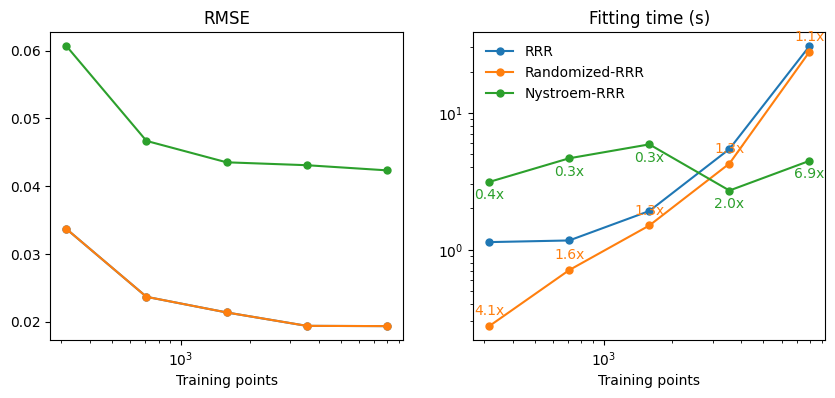

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")

